In [1]:

import os, sys
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
import torch.nn.functional as F
from tqdm import tqdm
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import numpy as np

In [9]:
MODEL='1b-v0'
CHECKPOINT=10000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).cuda()

In [10]:
idx_00 = np.load('../results/indices/0_0.npy')
idx_01 = np.load('../results/indices/0_1.npy')

In [11]:
dataset = MMapIndexedDataset('/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document', skip_warmup = True)
tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="/om/user/sunnyd/transformers_cache",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


In [12]:
MODEL='1b-v0'
CHECKPOINT=10000
model_orig = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).cuda()
# data = dataset[1000][None, :]

In [13]:

    
def compute_dist(batch):
    model = GPTNeoXForCausalLM.from_pretrained(
        f"EleutherAI/pythia-{MODEL}",
        use_cache=False,
        revision = f'step{CHECKPOINT}',
        cache_dir=f"/om/user/sunnyd/transformers_cache/"
    ).cuda()
    
    batch = torch.tensor(batch.astype(np.int32)).type(torch.LongTensor).cuda()
    x, y = batch[:, :-1], batch[:, 1:]
    opt = torch.optim.SGD(
                params=model.parameters(),
                lr=1e-5,
                # weight_decay=1e-1,
                # betas=(0.9, 0.95),
                # optim_bits=8,
                # fused=True,
            )
    with torch.autocast(device_type="cuda", enabled=True):
        for i in range(100):
            opt.zero_grad()
            z = model(x).logits
            y = y.reshape(-1)
            z = z.view(-1, z.shape[-1])
            loss = F.cross_entropy(z, y)
            if i == 0:
                starting_loss = loss.detach().cpu().numpy()
            # bar.set_description(f'loss: {loss.detach().cpu()}')
            loss.backward()
            if loss < 0.5:
                break
            opt.step()
            
    param1 = dict(model.named_parameters())
    total_dist = 0
    for k, p2 in model_orig.named_parameters():
        total_dist += torch.sum(torch.square(p2 - param1[k]))
    return i, loss.detach().cpu().numpy(), total_dist.detach().cpu().numpy()

In [14]:
dists = []
for idx in tqdm(idx_00):
    batch = dataset[idx.astype(np.int32).item()][None, :96]
    dists.append(compute_dist(batch))

 26%|██▌       | 255/1000 [23:47<1:09:29,  5.60s/it]


KeyboardInterrupt: 

In [17]:
steps, final_loss, total_dist = zip(*dists)
steps = np.array(steps)
final_loss = np.array(final_loss)
total_dist = np.array(total_dist)
# i, loss.detach().cpu().numpy(), total_dist.detach().cpu().numpy()

In [19]:
os.makedirs('../results/grad_steps', exist_ok=True)
np.savez('../results/grad_steps/00', steps=steps, final_loss=final_loss, total_dist=total_dist)

In [121]:
tokenizer.decode(data[0, :32])

' camera is over there.\nThank you very much.\nYou saved a child, saved a family.\n<|endoftext|>/*\n * Copyright (c) 2017 Spot'

In [112]:
tokenizer.decode(data[0, 32:96])

'ify AB.\n *\n * Licensed to the Apache Software Foundation (ASF) under one\n * or more contributor license agreements.  See the NOTICE file\n * distributed with this work for additional information\n * regarding copyright ownership.  The ASF licenses this file\n * to you under the Apache License, Version'

In [9]:
outputs = model(torch.tensor(data.astype(np.int32)).to('cuda')[:, :32], labels=torch.tensor(data.astype(np.int32)).to('cuda')[:, :32])
gen = np.argmax(outputs.logits[0, :].cpu().detach().numpy(), axis=1)[None, :]
# levenshtein_distance(gen, data[:, 32:64])

NameError: name 'data' is not defined

In [114]:
tokenizer.decode(np.argmax(outputs.logits[0, :].cpu().detach().numpy(), axis=1))


'. a the.\n\n you for much for\n\n can my lot. and a life.\n\nQ\n * Copyright (C) 2018,ify'

In [104]:
outputs.logits.shape

torch.Size([1, 32, 50304])

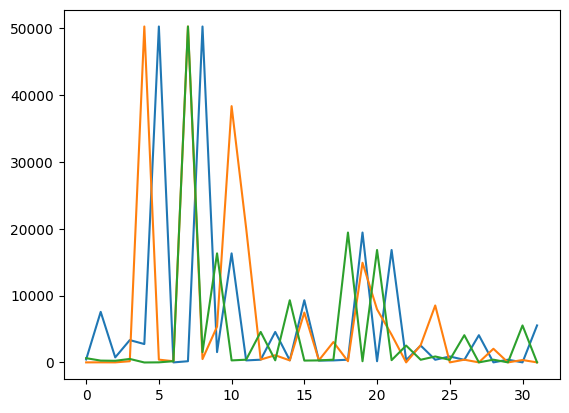

In [106]:
plt.plot(data[0, :32])
plt.plot(data[0, 32:64])
plt.plot(np.argmax(outputs.logits[0, :].cpu().detach().numpy(), axis=1))

In [77]:
from numba import guvectorize
@guvectorize(["void(int64[:,:], int64[:,:], int64[:])"],
             "(n,i),(n,j)->(n)")
def levenshtein_distance(a, b, result):
    d = np.zeros((a.shape[0], a.shape[1]+1, 2))
    for i in range(0, a.shape[1]+1):
        d[:, i, 0] = i
    for j in range(1, b.shape[1]+1):
        d[:, 0, j % 2] = j
        for i in range(1, a.shape[1]+1):
            substitution_cost = (a[:, i-1] != b[:, j-1])
            for k in range(a.shape[0]):
                d[k, i, j % 2] = min(
                        (d[k, i-1, j % 2] + 1,
                         d[k, i, (j-1) % 2] + 1,
                         d[k, i-1, (j-1) % 2] + substitution_cost[k]
                        )
                )
    result[:] = d[:, -1, (b.shape[-1]) % 2]


array([30])